## 1. Environment Setup and Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ All libraries imported successfully
Analysis Date: 2025-09-30 21:02:41


## 2. Database Connection and Data Extraction

In [3]:
# Connect to SQLite database
db_path = '../data/ecommerce.db'
conn = sqlite3.connect(db_path)

print(f"✓ Connected to database: {db_path}")

✓ Connected to database: ../data/ecommerce.db


In [4]:
try:
    # Try to read from database first
    df = pd.read_sql_query("SELECT * FROM transactions LIMIT 5", conn)
    print("✓ Database exists, loading data...")
    df = pd.read_sql_query("SELECT * FROM transactions", conn)
except:
    print("Creating database from CSV file...")
    # Read the CSV file
    df = pd.read_csv('../data/online_retail_II.csv', encoding='ISO-8859-1')
    
    # Rename columns to match our schema
    df.columns = ['invoice_no', 'stock_code', 'description', 'quantity', 
                  'invoice_date', 'unit_price', 'customer_id', 'country']
    
    # Initial save to database
    df.to_sql('transactions_raw', conn, if_exists='replace', index=False)
    print("✓ Raw data loaded to database")

✓ Database exists, loading data...


In [5]:
# Display basic information
print(f"\nDataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
df.head()


Dataset Shape: (757339, 17)
Columns: ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country', 'total_price', 'year', 'month', 'day_of_week', 'day', 'hour', 'quarter', 'month_name', 'day_name']

First few rows:


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,total_price,year,month,day_of_week,day,hour,quarter,month_name,day_name
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009,12,1,1,7,4,December,Tuesday
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,1,1,7,4,December,Tuesday
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,1,1,7,4,December,Tuesday
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009,12,1,1,7,4,December,Tuesday
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009,12,1,1,7,4,December,Tuesday


## 3. Data Cleaning and Preprocessing

In [6]:
print("="*60)
print("DATA CLEANING PROCESS")
print("="*60)

# Check initial data quality
print("\n1. Missing Values:")
print(df.isnull().sum())
print(f"\nMissing CustomerID: {df['customer_id'].isnull().sum()} ({df['customer_id'].isnull().sum()/len(df)*100:.2f}%)")

# Check data types
print("\n2. Data Types:")
print(df.dtypes)

# Check for duplicates
print(f"\n3. Duplicate Rows: {df.duplicated().sum()}")

# Store original size
original_size = len(df)
print(f"\n4. Original Dataset Size: {original_size:,} rows")

DATA CLEANING PROCESS

1. Missing Values:
invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
total_price     0
year            0
month           0
day_of_week     0
day             0
hour            0
quarter         0
month_name      0
day_name        0
dtype: int64

Missing CustomerID: 0 (0.00%)

2. Data Types:
invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id      object
country          object
total_price     float64
year              int64
month             int64
day_of_week       int64
day               int64
hour              int64
quarter           int64
month_name       object
day_name         object
dtype: object

3. Duplicate Rows: 0

4. Original Dataset Size: 757,339 rows


In [7]:
# CLEANING STEP 1: Remove rows with missing CustomerID
# These transactions cannot be used for customer analysis
df_clean = df[df['customer_id'].notna()].copy()
print(f"\n✓ Removed rows with missing CustomerID: {original_size - len(df_clean):,} rows")

# CLEANING STEP 2: Remove duplicate transactions
df_clean = df_clean.drop_duplicates()
print(f"✓ Removed duplicate rows: {len(df) - len(df_clean):,} rows")

# CLEANING STEP 3: Convert data types
df_clean['invoice_date'] = pd.to_datetime(df_clean['invoice_date'])
df_clean['customer_id'] = df_clean['customer_id'].astype(str)
df_clean['quantity'] = pd.to_numeric(df_clean['quantity'], errors='coerce')
df_clean['unit_price'] = pd.to_numeric(df_clean['unit_price'], errors='coerce')

print("✓ Converted data types (dates, numeric values)")

# CLEANING STEP 4: Remove invalid transactions
# Remove transactions with negative or zero quantities (returns/errors)
# Remove transactions with zero or negative prices
df_clean = df_clean[
    (df_clean['quantity'] > 0) & 
    (df_clean['unit_price'] > 0)
]
print(f"✓ Removed invalid transactions (negative/zero quantities or prices)")

# CLEANING STEP 5: Remove outliers
# Remove extreme outliers in quantity and price
quantity_99 = df_clean['quantity'].quantile(0.99)
price_99 = df_clean['unit_price'].quantile(0.99)

df_clean = df_clean[
    (df_clean['quantity'] <= quantity_99) &
    (df_clean['unit_price'] <= price_99)
]
print(f"✓ Removed extreme outliers (>99th percentile)")

print(f"\nFinal Clean Dataset Size: {len(df_clean):,} rows")
print(f"Rows Removed: {original_size - len(df_clean):,} ({(original_size - len(df_clean))/original_size*100:.2f}%)")



✓ Removed rows with missing CustomerID: 0 rows
✓ Removed duplicate rows: 0 rows
✓ Converted data types (dates, numeric values)
✓ Removed invalid transactions (negative/zero quantities or prices)
✓ Removed extreme outliers (>99th percentile)

Final Clean Dataset Size: 753,248 rows
Rows Removed: 4,091 (0.54%)


## 4. Feature Engineering

In [8]:
print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

# Create new features
# Total Price per transaction line
df_clean['total_price'] = df_clean['quantity'] * df_clean['unit_price']

# Extract temporal features
df_clean['year'] = df_clean['invoice_date'].dt.year
df_clean['month'] = df_clean['invoice_date'].dt.month
df_clean['day'] = df_clean['invoice_date'].dt.day
df_clean['day_of_week'] = df_clean['invoice_date'].dt.dayofweek
df_clean['hour'] = df_clean['invoice_date'].dt.hour
df_clean['quarter'] = df_clean['invoice_date'].dt.quarter

# Month name for better visualization
df_clean['month_name'] = df_clean['invoice_date'].dt.month_name()

# Day name for better visualization
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_clean['day_name'] = df_clean['day_of_week'].apply(lambda x: day_names[x])

print("✓ Created total_price feature")
print("✓ Extracted temporal features: year, month, day, day_of_week, hour, quarter")
print("\nFeature Summary:")
print(df_clean[['total_price', 'year', 'month', 'quarter']].describe())

# Save cleaned data to database
df_clean.to_sql('transactions', conn, if_exists='replace', index=False)
print("\n✓ Clean data saved to database")


FEATURE ENGINEERING
✓ Created total_price feature
✓ Extracted temporal features: year, month, day, day_of_week, hour, quarter

Feature Summary:
         total_price           year          month        quarter
count  753248.000000  753248.000000  753248.000000  753248.000000
mean       16.405850    2010.431519       7.426623       2.800079
std        23.984275       0.568481       3.421802       1.132035
min         0.001000    2009.000000       1.000000       1.000000
25%         4.950000    2010.000000       5.000000       2.000000
50%        11.400000    2010.000000       8.000000       3.000000
75%        17.850000    2011.000000      11.000000       4.000000
max       867.000000    2011.000000      12.000000       4.000000

✓ Clean data saved to database


## 5. Exploratory Data Analysis (EDA)

In [9]:
print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)


EXPLORATORY DATA ANALYSIS


### 5.1 Overall Business Metrics

In [10]:
print("\n📊 OVERALL BUSINESS METRICS")
print("-" * 60)

total_revenue = df_clean['total_price'].sum()
total_transactions = df_clean['invoice_no'].nunique()
total_customers = df_clean['customer_id'].nunique()
total_products = df_clean['stock_code'].nunique()
total_countries = df_clean['country'].nunique()
avg_transaction_value = total_revenue / total_transactions
date_range = f"{df_clean['invoice_date'].min().date()} to {df_clean['invoice_date'].max().date()}"

print(f"Date Range:              {date_range}")
print(f"Total Revenue:           £{total_revenue:,.2f}")
print(f"Total Transactions:      {total_transactions:,}")
print(f"Unique Customers:        {total_customers:,}")
print(f"Unique Products:         {total_products:,}")
print(f"Countries Served:        {total_countries}")
print(f"Avg Transaction Value:   £{avg_transaction_value:.2f}")


📊 OVERALL BUSINESS METRICS
------------------------------------------------------------
Date Range:              2009-12-01 to 2011-12-09
Total Revenue:           £12,357,673.59
Total Transactions:      35,216
Unique Customers:        5,766
Unique Products:         4,534
Countries Served:        41
Avg Transaction Value:   £350.91


### 5.2 Temporal Analysis


📈 TEMPORAL ANALYSIS
------------------------------------------------------------


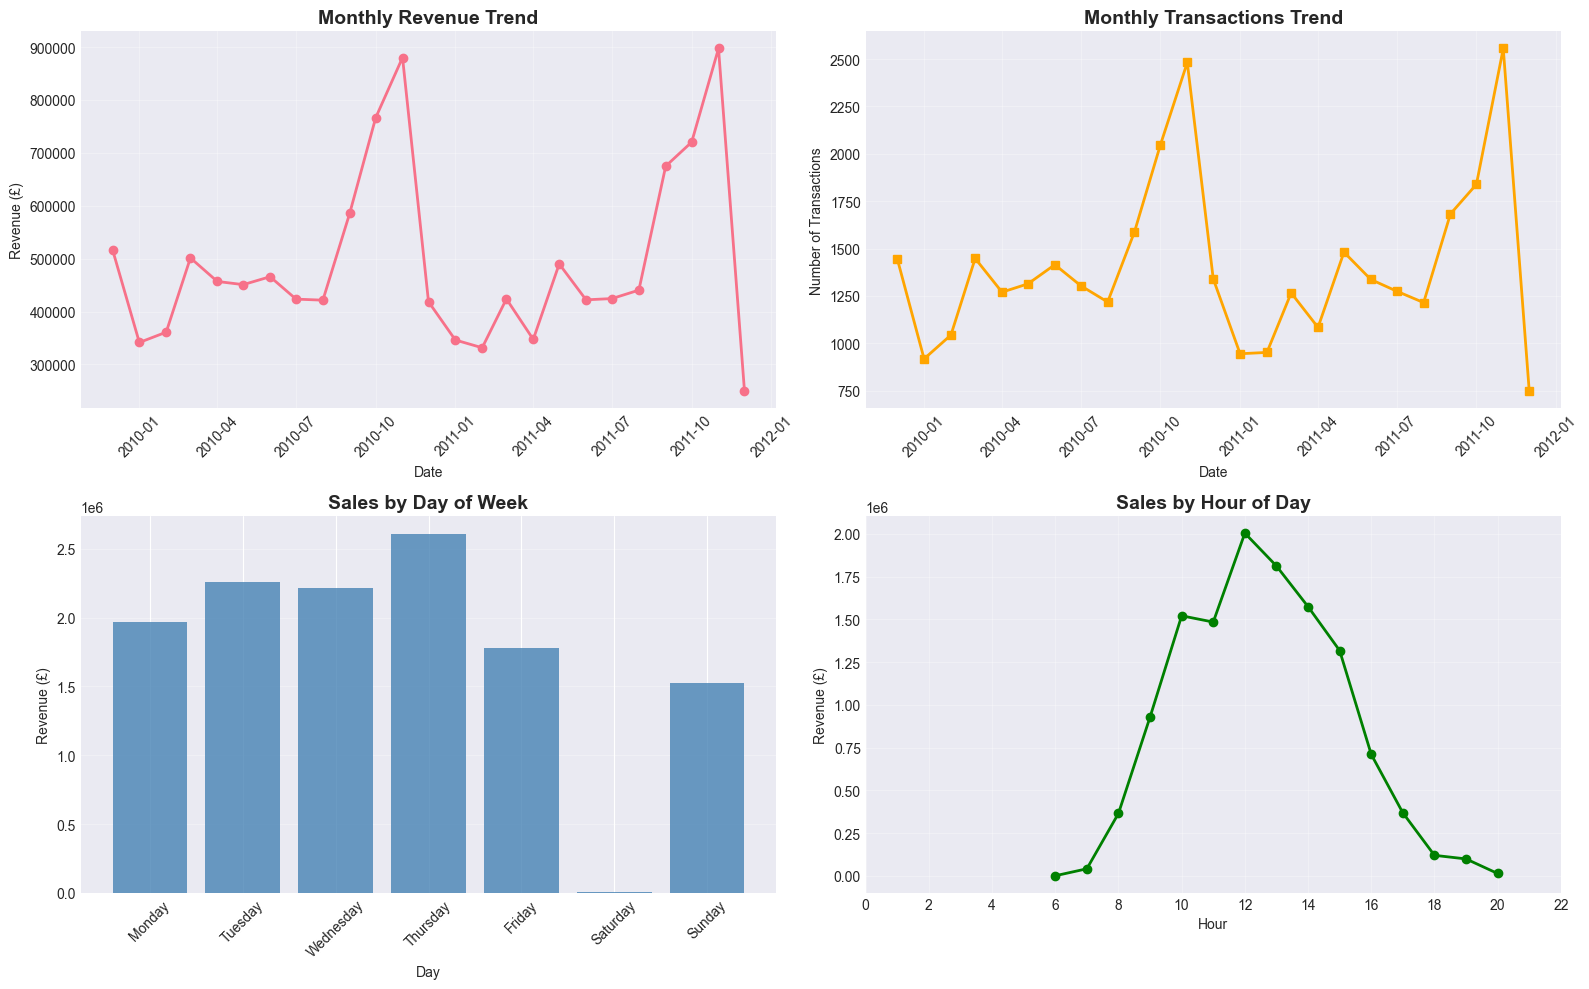

✓ Temporal analysis charts created


In [11]:
print("\n📈 TEMPORAL ANALYSIS")
print("-" * 60)

# Monthly sales trend
monthly_sales = df_clean.groupby(['year', 'month']).agg({
    'total_price': 'sum',
    'invoice_no': 'nunique',
    'customer_id': 'nunique'
}).reset_index()

monthly_sales['year_month'] = pd.to_datetime(
    monthly_sales['year'].astype(str) + '-' + monthly_sales['month'].astype(str)
)

# Plot monthly revenue trend
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Revenue over time
axes[0, 0].plot(monthly_sales['year_month'], monthly_sales['total_price'], 
                marker='o', linewidth=2, markersize=6)
axes[0, 0].set_title('Monthly Revenue Trend', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Revenue (£)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Transactions over time
axes[0, 1].plot(monthly_sales['year_month'], monthly_sales['invoice_no'], 
                marker='s', linewidth=2, markersize=6, color='orange')
axes[0, 1].set_title('Monthly Transactions Trend', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Number of Transactions')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Sales by day of week
daily_pattern = df_clean.groupby('day_name')['total_price'].sum().reindex(day_names)
axes[1, 0].bar(range(len(day_names)), daily_pattern.values, color='steelblue', alpha=0.8)
axes[1, 0].set_title('Sales by Day of Week', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Day')
axes[1, 0].set_ylabel('Revenue (£)')
axes[1, 0].set_xticks(range(len(day_names)))
axes[1, 0].set_xticklabels(day_names, rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Sales by hour
hourly_sales = df_clean.groupby('hour')['total_price'].sum()
axes[1, 1].plot(hourly_sales.index, hourly_sales.values, marker='o', linewidth=2, color='green')
axes[1, 1].set_title('Sales by Hour of Day', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('Revenue (£)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.savefig('../images/temporal_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Temporal analysis charts created")

### 5.4 Product Analysis


🏆 PRODUCT ANALYSIS
------------------------------------------------------------
Top 10 Products by Revenue:
                       description   revenue  quantity_sold
          REGENCY CAKESTAND 3 TIER 227130.85          19529
WHITE HANGING HEART T-LIGHT HOLDER 163482.20          59910
                     PARTY BUNTING  84039.98          18672
     ASSORTED COLOUR BIRD ORNAMENT  67209.41          39845
           JUMBO BAG RED RETROSPOT  49786.40          24906
                     CHILLI LIGHTS  49419.10          10347
   PAPER CHAIN KIT 50'S CHRISTMAS   46077.38          16314
        CHOCOLATE HOT WATER BOTTLE  43357.34           9376
        VINTAGE UNION JACK BUNTING  42908.71           5052
          HOME BUILDING BLOCK WORD  42453.11           7231


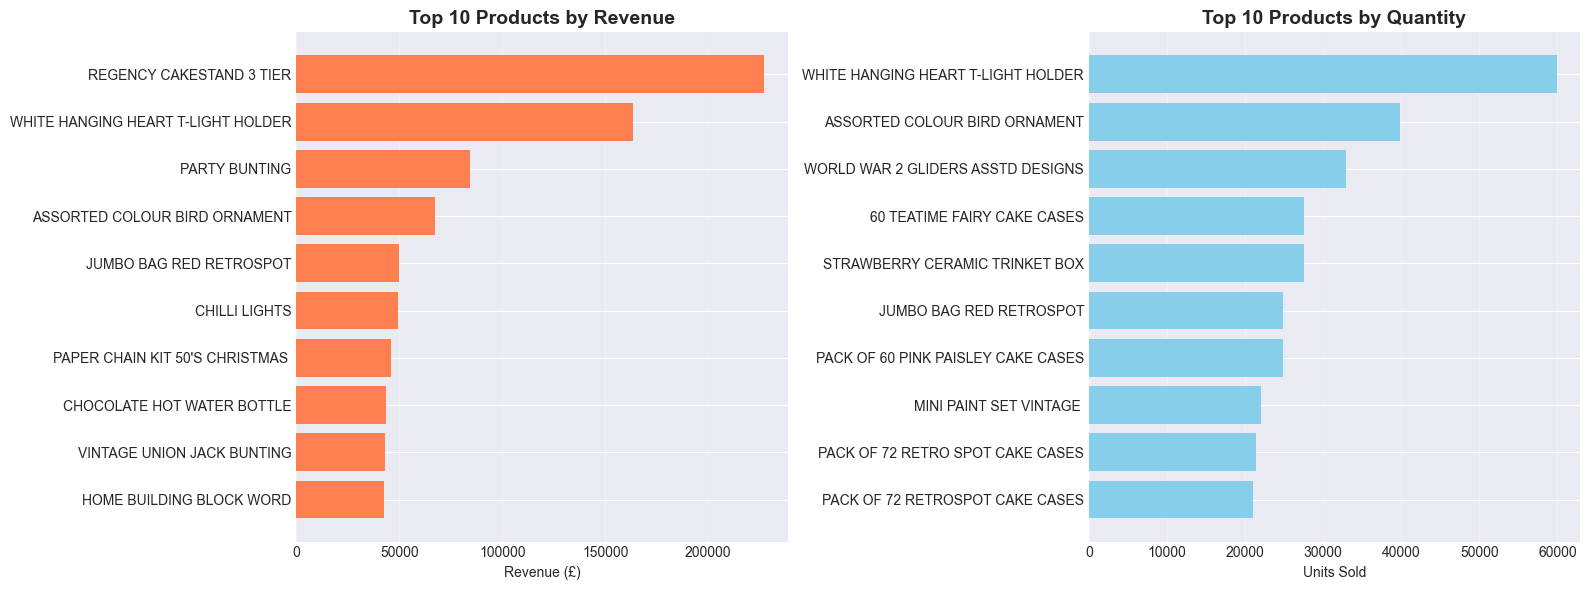


✓ Product analysis charts created


In [12]:
print("\n🏆 PRODUCT ANALYSIS")
print("-" * 60)

# Top products by revenue
product_revenue = df_clean.groupby(['stock_code', 'description']).agg({
    'total_price': 'sum',
    'quantity': 'sum',
    'invoice_no': 'nunique'
}).reset_index()

product_revenue.columns = ['stock_code', 'description', 'revenue', 'quantity_sold', 'times_purchased']
product_revenue = product_revenue.sort_values('revenue', ascending=False)

print("Top 10 Products by Revenue:")
print(product_revenue.head(10)[['description', 'revenue', 'quantity_sold']].to_string(index=False))

# Visualize top products
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 by revenue
top_10_revenue = product_revenue.head(10)
axes[0].barh(range(len(top_10_revenue)), top_10_revenue['revenue'].values, color='coral')
axes[0].set_yticks(range(len(top_10_revenue)))
axes[0].set_yticklabels(top_10_revenue['description'].str[:40])
axes[0].set_xlabel('Revenue (£)')
axes[0].set_title('Top 10 Products by Revenue', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Top 10 by quantity
top_10_quantity = product_revenue.sort_values('quantity_sold', ascending=False).head(10)
axes[1].barh(range(len(top_10_quantity)), top_10_quantity['quantity_sold'].values, color='skyblue')
axes[1].set_yticks(range(len(top_10_quantity)))
axes[1].set_yticklabels(top_10_quantity['description'].str[:40])
axes[1].set_xlabel('Units Sold')
axes[1].set_title('Top 10 Products by Quantity', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../images/top_products.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Product analysis charts created")

### 5.4 Geographic Analysis


🌍 GEOGRAPHIC ANALYSIS
------------------------------------------------------------
Top 10 Countries by Revenue:
       country      revenue  transactions  customers
United Kingdom 10540570.867         32078       5252
          EIRE   384326.790           516          3
       Germany   352425.121           747        107
        France   260731.790           582         93
   Netherlands   168275.080           190         22
   Switzerland    82072.460            80         22
         Spain    65339.590           141         37
     Australia    63786.400            84         15
       Belgium    53881.990           141         29
      Portugal    45588.030            82         23


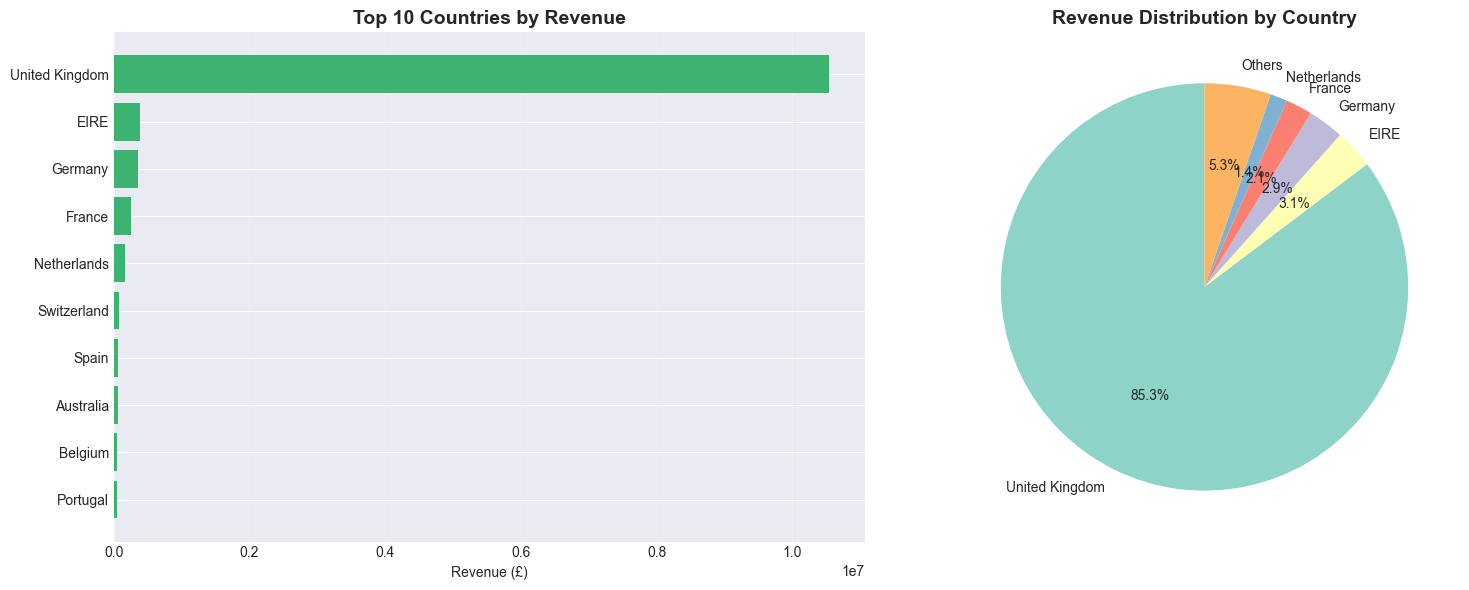


✓ Geographic analysis charts created


In [13]:
print("\n🌍 GEOGRAPHIC ANALYSIS")
print("-" * 60)

# Sales by country
country_sales = df_clean.groupby('country').agg({
    'total_price': 'sum',
    'invoice_no': 'nunique',
    'customer_id': 'nunique'
}).reset_index()

country_sales.columns = ['country', 'revenue', 'transactions', 'customers']
country_sales = country_sales.sort_values('revenue', ascending=False)

print("Top 10 Countries by Revenue:")
print(country_sales.head(10).to_string(index=False))

# Calculate percentage of total revenue
country_sales['revenue_pct'] = (country_sales['revenue'] / country_sales['revenue'].sum() * 100)

# Visualize geographic distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 countries by revenue
top_10_countries = country_sales.head(10)
axes[0].barh(range(len(top_10_countries)), top_10_countries['revenue'].values, color='mediumseagreen')
axes[0].set_yticks(range(len(top_10_countries)))
axes[0].set_yticklabels(top_10_countries['country'])
axes[0].set_xlabel('Revenue (£)')
axes[0].set_title('Top 10 Countries by Revenue', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Revenue concentration pie chart (top 5 + others)
top_5_countries = country_sales.head(5)
others_revenue = country_sales.iloc[5:]['revenue'].sum()
pie_data = list(top_5_countries['revenue'].values) + [others_revenue]
pie_labels = list(top_5_countries['country'].values) + ['Others']
colors = plt.cm.Set3(range(len(pie_labels)))

axes[1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title('Revenue Distribution by Country', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../images/geographic_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Geographic analysis charts created")

## 6. RFM Analysis and Customer Segmentation

In [14]:
print("\n" + "="*60)
print("RFM ANALYSIS AND CUSTOMER SEGMENTATION")
print("="*60)

# Calculate RFM metrics
# Reference date: one day after the last transaction in the dataset
reference_date = df_clean['invoice_date'].max() + pd.Timedelta(days=1)
print(f"\nReference Date for Recency: {reference_date.date()}")

# Calculate RFM values for each customer
rfm = df_clean.groupby('customer_id').agg({
    'invoice_date': lambda x: (reference_date - x.max()).days,  # Recency
    'invoice_no': 'nunique',  # Frequency
    'total_price': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

print(f"\nRFM Data Shape: {rfm.shape}")
print("\nRFM Statistics:")
print(rfm[['recency', 'frequency', 'monetary']].describe())


RFM ANALYSIS AND CUSTOMER SEGMENTATION

Reference Date for Recency: 2011-12-10

RFM Data Shape: (5766, 4)

RFM Statistics:
           recency    frequency       monetary
count  5766.000000  5766.000000    5766.000000
mean    200.197711     6.107527    2143.196946
std     208.607987    12.146913    6078.482594
min       1.000000     1.000000       2.900000
25%      26.000000     1.000000     317.105000
50%      95.000000     3.000000     786.585000
75%     379.000000     7.000000    2015.792500
max     739.000000   371.000000  248545.410000


### 6.1 RFM Score Calculation


✓ RFM scores calculated


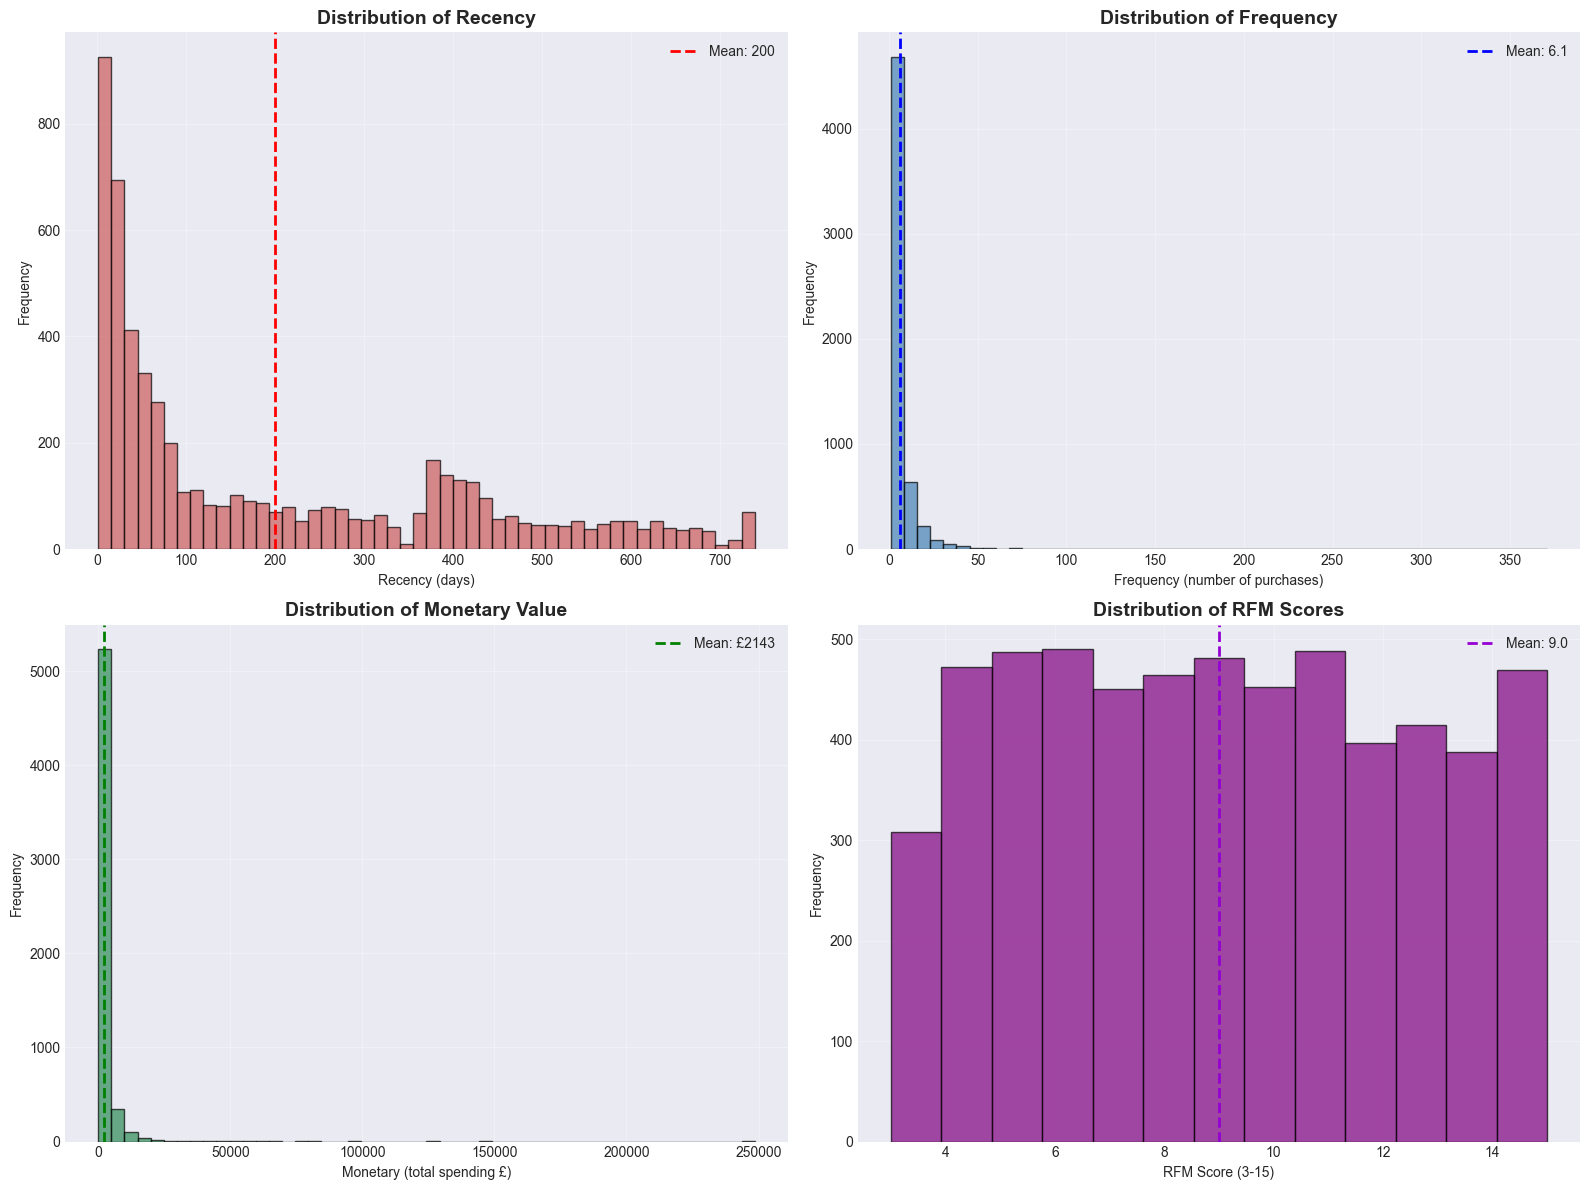

✓ RFM distribution charts created


In [15]:
# Create RFM scores (1-5 scale, 5 being best)
# For Recency: lower is better (more recent)
# For Frequency and Monetary: higher is better

rfm['r_score'] = pd.qcut(rfm['recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm['m_score'] = pd.qcut(rfm['monetary'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# Convert to numeric
rfm['r_score'] = rfm['r_score'].astype(int)
rfm['f_score'] = rfm['f_score'].astype(int)
rfm['m_score'] = rfm['m_score'].astype(int)

# Calculate RFM combined score
rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)
rfm['rfm_score_numeric'] = rfm['r_score'] + rfm['f_score'] + rfm['m_score']

print("\n✓ RFM scores calculated")

# Visualize RFM distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Recency distribution
axes[0, 0].hist(rfm['recency'], bins=50, color='indianred', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Recency (days)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Recency', fontsize=14, fontweight='bold')
axes[0, 0].axvline(rfm['recency'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {rfm["recency"].mean():.0f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Frequency distribution
axes[0, 1].hist(rfm['frequency'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Frequency (number of purchases)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Frequency', fontsize=14, fontweight='bold')
axes[0, 1].axvline(rfm['frequency'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {rfm["frequency"].mean():.1f}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Monetary distribution
axes[1, 0].hist(rfm['monetary'], bins=50, color='seagreen', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Monetary (total spending £)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Monetary Value', fontsize=14, fontweight='bold')
axes[1, 0].axvline(rfm['monetary'].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: £{rfm["monetary"].mean():.0f}')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# RFM Score distribution
axes[1, 1].hist(rfm['rfm_score_numeric'], bins=13, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('RFM Score (3-15)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of RFM Scores', fontsize=14, fontweight='bold')
axes[1, 1].axvline(rfm['rfm_score_numeric'].mean(), color='darkviolet', linestyle='--', linewidth=2, label=f'Mean: {rfm["rfm_score_numeric"].mean():.1f}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/rfm_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ RFM distribution charts created")


### 6.2 K-Means Clustering for Customer Segmentation


🎯 K-MEANS CLUSTERING
------------------------------------------------------------
✓ Data standardized for clustering

Calculating optimal clusters...


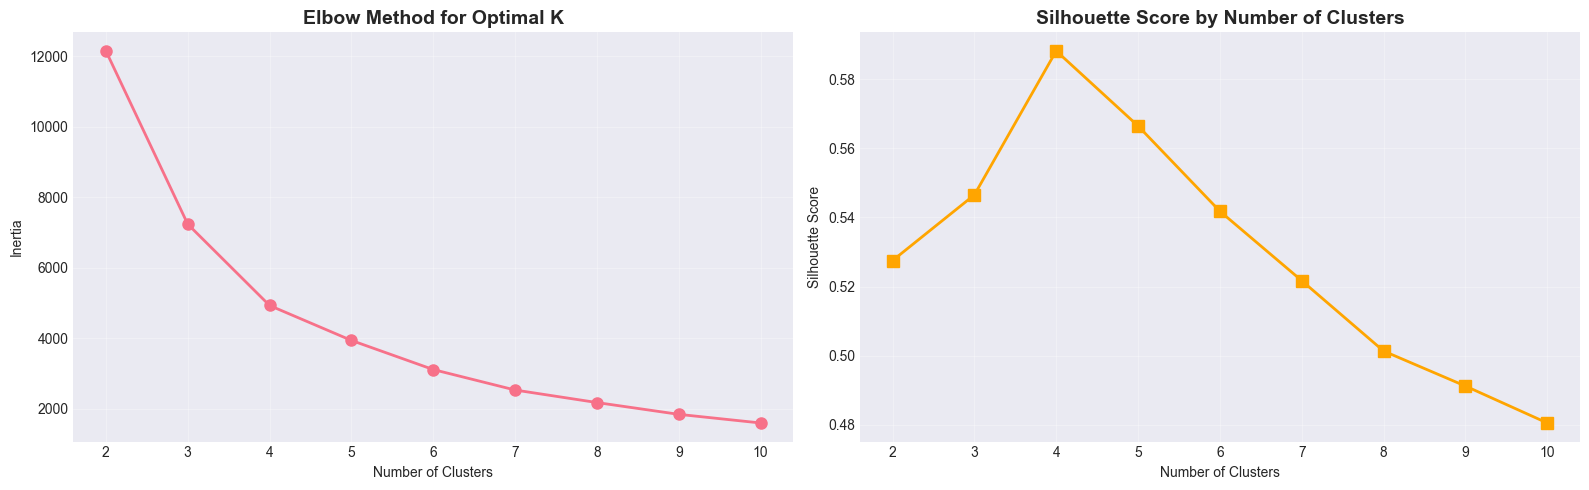


✓ Optimal number of clusters: 4
✓ K-Means clustering completed
Silhouette Score: 0.588


In [16]:
print("\n🎯 K-MEANS CLUSTERING")
print("-" * 60)

# Prepare data for clustering
rfm_clustering = rfm[['recency', 'frequency', 'monetary']].copy()

# Standardize the features (important for K-Means)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clustering)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['recency_scaled', 'frequency_scaled', 'monetary_scaled'])

print("✓ Data standardized for clustering")

# Find optimal number of clusters using Elbow Method and Silhouette Score
inertias = []
silhouette_scores = []
k_range = range(2, 11)

print("\nCalculating optimal clusters...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score by Number of Clusters', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/optimal_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

# Based on analysis, use 4 clusters
optimal_k = 4
print(f"\n✓ Optimal number of clusters: {optimal_k}")

# Perform K-Means clustering with optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['cluster'] = kmeans_final.fit_predict(rfm_scaled)

print(f"✓ K-Means clustering completed")
print(f"Silhouette Score: {silhouette_score(rfm_scaled, rfm['cluster']):.3f}")

### 6.3 Analyze Customer Segments


📊 CUSTOMER SEGMENT ANALYSIS
------------------------------------------------------------

Segment Statistics:
 cluster  customer_count  avg_recency  avg_frequency  avg_monetary  percentage
       2              13    31.692308     171.461538  88129.748462    0.225460
       3             326    25.245399      30.957055  12694.363939    5.653833
       0            3507    72.181922       5.350442   1689.276445   60.822060
       1            1920   464.872917       2.151562    598.610272   33.298647

✓ Segment names assigned:
  Cluster 2: Champions (13 customers, 0.2%)
  Cluster 3: Champions (326 customers, 5.7%)
  Cluster 0: Loyal Customers (3507 customers, 60.8%)
  Cluster 1: Lost Customers (1920 customers, 33.3%)


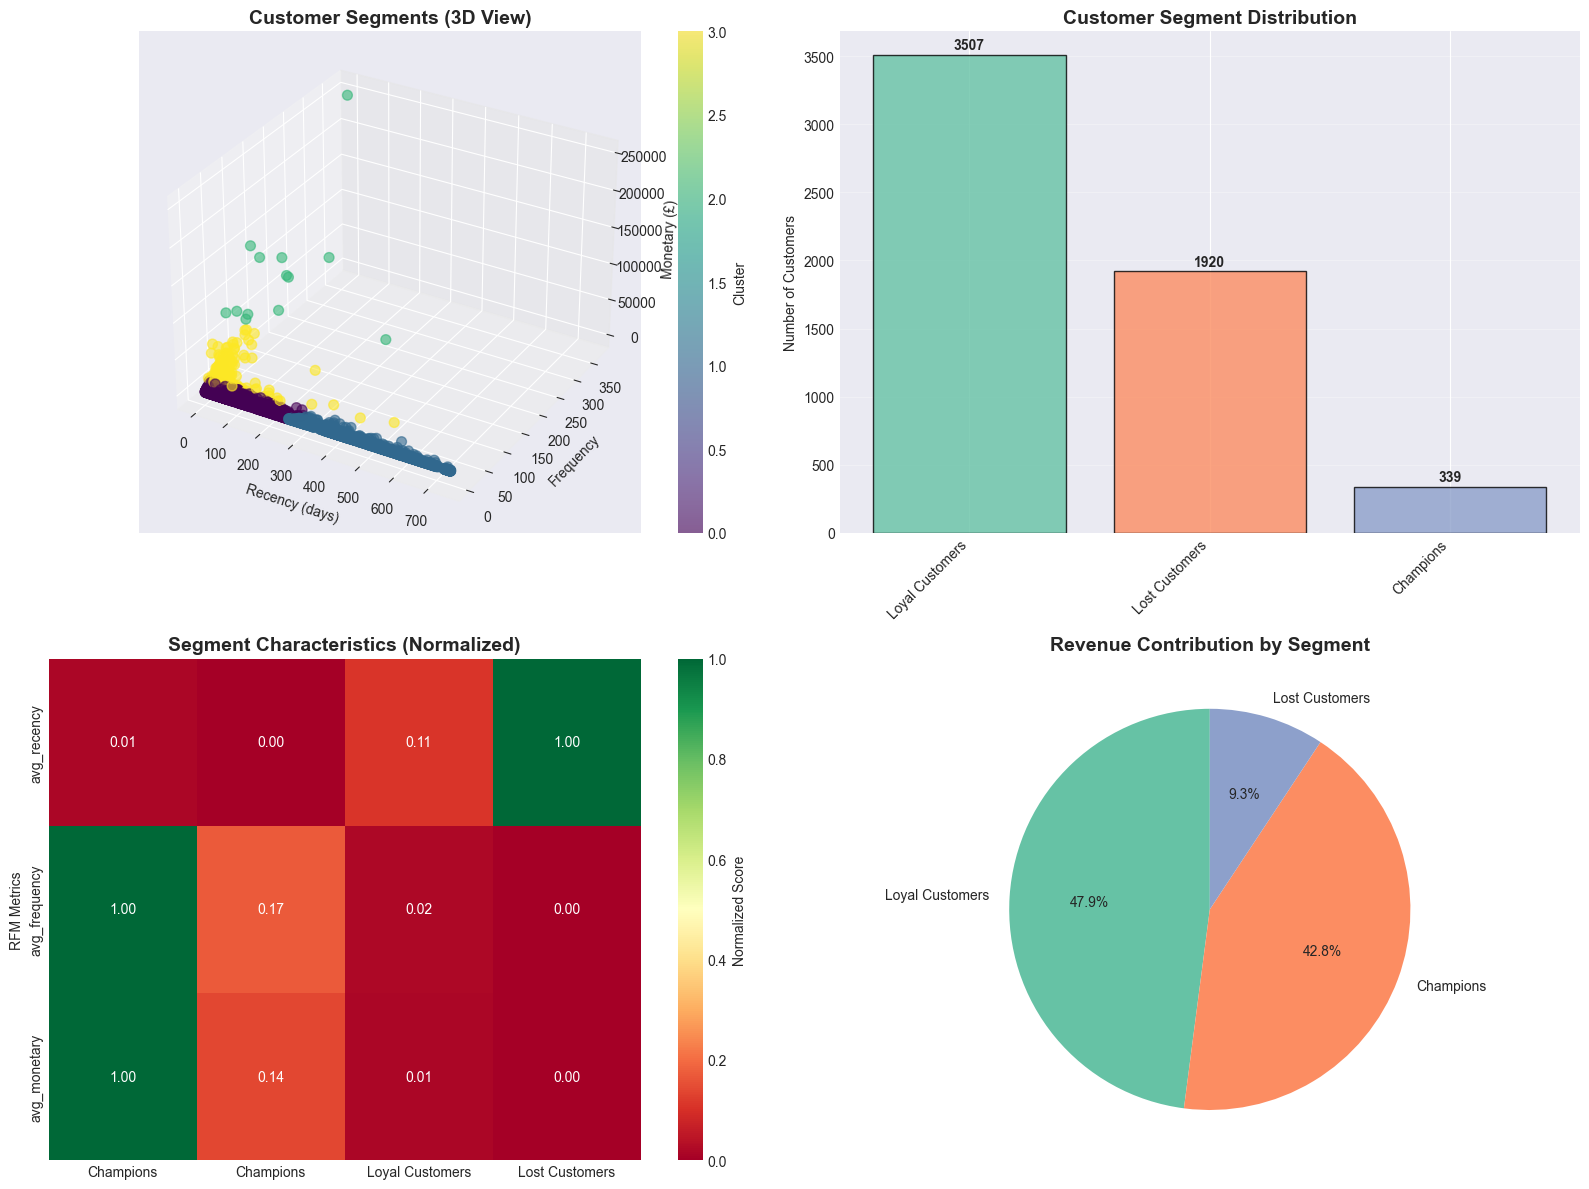


✓ Customer segmentation visualizations created


In [17]:
print("\n📊 CUSTOMER SEGMENT ANALYSIS")
print("-" * 60)

# Calculate segment statistics
segment_summary = rfm.groupby('cluster').agg({
    'customer_id': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
}).reset_index()

segment_summary.columns = ['cluster', 'customer_count', 'avg_recency', 'avg_frequency', 'avg_monetary']
segment_summary['percentage'] = (segment_summary['customer_count'] / segment_summary['customer_count'].sum() * 100)

# Sort by monetary value to identify segments
segment_summary = segment_summary.sort_values('avg_monetary', ascending=False)

print("\nSegment Statistics:")
print(segment_summary.to_string(index=False))

# Assign segment names based on RFM characteristics
def assign_segment_name(row):
    if row['avg_recency'] < 100 and row['avg_frequency'] > 5 and row['avg_monetary'] > 2000:
        return 'Champions'
    elif row['avg_recency'] < 150 and row['avg_frequency'] > 3:
        return 'Loyal Customers'
    elif row['avg_recency'] > 200 and row['avg_frequency'] > 3:
        return 'At Risk'
    else:
        return 'Lost Customers'

segment_summary['segment_name'] = segment_summary.apply(assign_segment_name, axis=1)

# Map segment names back to main RFM dataframe
segment_mapping = dict(zip(segment_summary['cluster'], segment_summary['segment_name']))
rfm['segment'] = rfm['cluster'].map(segment_mapping)

print("\n✓ Segment names assigned:")
for cluster, name in segment_mapping.items():
    count = len(rfm[rfm['cluster'] == cluster])
    pct = count / len(rfm) * 100
    print(f"  Cluster {cluster}: {name} ({count} customers, {pct:.1f}%)")

# Visualize customer segments
fig = plt.figure(figsize=(16, 12))

# 3D scatter plot
ax1 = fig.add_subplot(221, projection='3d')
scatter = ax1.scatter(rfm['recency'], rfm['frequency'], rfm['monetary'], 
                     c=rfm['cluster'], cmap='viridis', alpha=0.6, s=50)
ax1.set_xlabel('Recency (days)')
ax1.set_ylabel('Frequency')
ax1.set_zlabel('Monetary (£)')
ax1.set_title('Customer Segments (3D View)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=ax1, label='Cluster')

# Segment size distribution
ax2 = fig.add_subplot(222)
segment_counts = rfm['segment'].value_counts()
colors_seg = plt.cm.Set2(range(len(segment_counts)))
ax2.bar(range(len(segment_counts)), segment_counts.values, color=colors_seg, alpha=0.8, edgecolor='black')
ax2.set_xticks(range(len(segment_counts)))
ax2.set_xticklabels(segment_counts.index, rotation=45, ha='right')
ax2.set_ylabel('Number of Customers')
ax2.set_title('Customer Segment Distribution', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(segment_counts.values):
    ax2.text(i, v + 20, str(v), ha='center', va='bottom', fontweight='bold')

# Segment characteristics heatmap
ax3 = fig.add_subplot(223)
segment_pivot = segment_summary[['segment_name', 'avg_recency', 'avg_frequency', 'avg_monetary']].set_index('segment_name')
segment_pivot_normalized = (segment_pivot - segment_pivot.min()) / (segment_pivot.max() - segment_pivot.min())
sns.heatmap(segment_pivot_normalized.T, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax3, cbar_kws={'label': 'Normalized Score'})
ax3.set_title('Segment Characteristics (Normalized)', fontsize=14, fontweight='bold')
ax3.set_xlabel('')
ax3.set_ylabel('RFM Metrics')

# Revenue contribution by segment
ax4 = fig.add_subplot(224)
segment_revenue = rfm.groupby('segment')['monetary'].sum().sort_values(ascending=False)
ax4.pie(segment_revenue.values, labels=segment_revenue.index, autopct='%1.1f%%', startangle=90, colors=colors_seg)
ax4.set_title('Revenue Contribution by Segment', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../images/customer_segments.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Customer segmentation visualizations created")

## 7. Business Insights and Recommendations

In [18]:
print("\n" + "="*60)
print("BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("="*60)

print("\n📋 KEY FINDINGS SUMMARY")
print("-" * 60)

# 1. Overall Performance
print("\n1. OVERALL BUSINESS PERFORMANCE")
print(f"   • Total Revenue: £{total_revenue:,.2f}")
print(f"   • Active Customers: {total_customers:,}")
print(f"   • Average Customer Value: £{rfm['monetary'].mean():,.2f}")
print(f"   • Average Transaction: £{avg_transaction_value:.2f}")

# 2. Temporal Insights
peak_month = monthly_sales.loc[monthly_sales['total_price'].idxmax()]
print(f"\n2. TEMPORAL PATTERNS")
print(f"   • Peak Sales Month: {peak_month['year']}-{peak_month['month']:02d} (£{peak_month['total_price']:,.2f})")
print(f"   • Best Day of Week: {daily_pattern.idxmax()} (£{daily_pattern.max():,.2f})")

# 3. Product Insights
print(f"\n3. PRODUCT PERFORMANCE")
print(f"   • Top Product: {top_10_revenue.iloc[0]['description']}")
print(f"   • Top Product Revenue: £{top_10_revenue.iloc[0]['revenue']:,.2f}")
print(f"   • Product Catalog Size: {total_products:,} unique products")

# 4. Geographic Insights
uk_revenue = country_sales[country_sales['country'] == 'United Kingdom']['revenue'].values[0]
uk_pct = uk_revenue / total_revenue * 100
print(f"\n4. GEOGRAPHIC DISTRIBUTION")
print(f"   • Top Market: United Kingdom ({uk_pct:.1f}% of revenue)")
print(f"   • International Markets: {total_countries - 1} countries")
print(f"   • Top International Market: {country_sales.iloc[1]['country']}")

# 5. Customer Segment Insights
print(f"\n5. CUSTOMER SEGMENTS")
for _, row in segment_summary.iterrows():
    print(f"   • {row['segment_name']}: {row['customer_count']} customers ({row['percentage']:.1f}%)")
    print(f"     - Avg Recency: {row['avg_recency']:.0f} days")
    print(f"     - Avg Frequency: {row['avg_frequency']:.1f} purchases")
    print(f"     - Avg Monetary: £{row['avg_monetary']:,.2f}")

print("\n" + "="*60)
print("✅ ANALYSIS COMPLETE!")
print("="*60)

# Save RFM results to database
rfm.to_sql('customer_rfm', conn, if_exists='replace', index=False)
segment_summary.to_sql('segment_summary', conn, if_exists='replace', index=False)

print("\n✓ Results saved to database")
print("✓ All visualizations saved to '../images/' directory")

# Close database connection
conn.close()
print("✓ Database connection closed")

print("\n" + "="*60)
print("Next Steps:")
print("1. Review visualizations in the 'images' folder")
print("2. Implement targeted marketing campaigns per segment")
print("3. Set up automated reporting dashboard")
print("4. Monitor segment migration over time")
print("="*60)


BUSINESS INSIGHTS AND RECOMMENDATIONS

📋 KEY FINDINGS SUMMARY
------------------------------------------------------------

1. OVERALL BUSINESS PERFORMANCE
   • Total Revenue: £12,357,673.59
   • Active Customers: 5,766
   • Average Customer Value: £2,143.20
   • Average Transaction: £350.91

2. TEMPORAL PATTERNS
   • Peak Sales Month: 2011-11 (£897,426.07)
   • Best Day of Week: Thursday (£2,607,525.42)

3. PRODUCT PERFORMANCE
   • Top Product: REGENCY CAKESTAND 3 TIER
   • Top Product Revenue: £227,130.85
   • Product Catalog Size: 4,534 unique products

4. GEOGRAPHIC DISTRIBUTION
   • Top Market: United Kingdom (85.3% of revenue)
   • International Markets: 40 countries
   • Top International Market: EIRE

5. CUSTOMER SEGMENTS
   • Champions: 13 customers (0.2%)
     - Avg Recency: 32 days
     - Avg Frequency: 171.5 purchases
     - Avg Monetary: £88,129.75
   • Champions: 326 customers (5.7%)
     - Avg Recency: 25 days
     - Avg Frequency: 31.0 purchases
     - Avg Monetary: £1